In [1]:
import gym
import torch
import copy
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from tqdm import tqdm
from collections import deque
import numpy as np

In [2]:
class DQN_Agent:

    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.q_net.cuda()
        self.target_net.cuda()
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen=exp_replay_size)
        return

    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index + 1])
            act = nn.Tanh() if index < len(layer_sizes) - 2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)

    def load_pretrained_model(self, model_path):
        self.q_net.load_state_dict(torch.load(model_path))

    def save_trained_model(self, model_path="cartpole-dqn.pth"):
        torch.save(self.q_net.state_dict(), model_path)

    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q, A = torch.max(Qp, axis=0)
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q, _ = torch.max(qp, axis=1)
        return q

    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        if self.network_sync_counter == self.network_sync_freq:
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0

        # predict expected return of current state using main network
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)

        # get target return using target network
        q_next = self.get_q_next(sn.cuda())
        target_return = rn.cuda() + self.gamma * q_next

        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        self.network_sync_counter += 1
        return loss.item()

In [3]:
env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 10000
epsilon = 1

# initiliaze experiance replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=64)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), reward_list.append(rew)

100%|██████████| 10000/10000 [07:54<00:00, 21.06it/s]


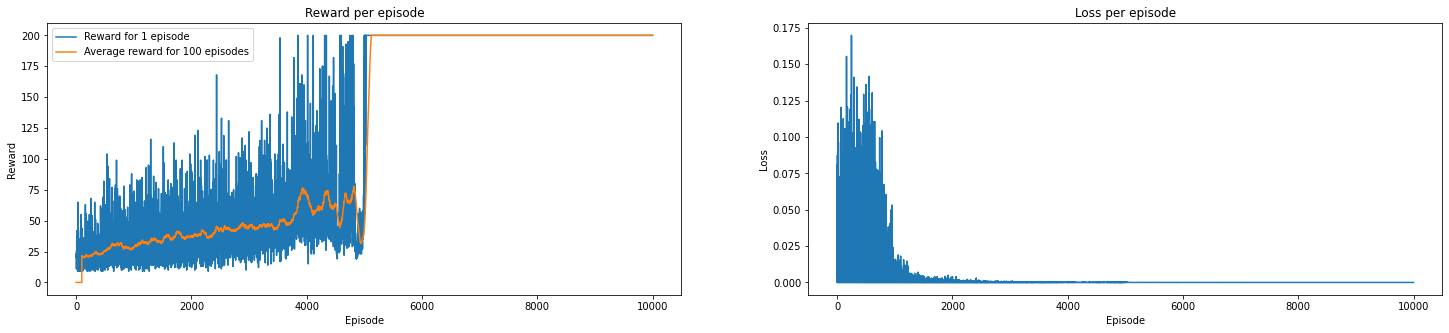

<Figure size 432x288 with 0 Axes>

In [10]:
reward_t = torch.tensor(reward_list, dtype=torch.float)
means = reward_t.unfold(0, 100, 1).mean(1).view(-1)
means = torch.cat((torch.zeros(99), means))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.set_title('Reward per episode')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.plot(reward_list, label='Reward for 1 episode')
ax1.plot(means, label='Average reward for 100 episodes')
ax1.legend(loc='best')

ax2.set_title('Loss per episode')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Loss')
ax2.plot(losses_list)
plt.show()

plt.savefig('Reward_n_loss.png', dpi=300)

In [11]:
agent.save_trained_model("cartpole-dqn.pth")

In [ ]:
import gym
from tqdm import tqdm
from time import sleep

env = gym.make('CartPole-v0').unwrapped
env = gym.wrappers.Monitor(env, "record_dir", force='True')

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)
agent.load_pretrained_model("cartpole-dqn.pth")

reward_arr = []
for i in tqdm(range(100)):
    obs, done, rew = env.reset(), False, 0
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=0)
        obs, reward, done, info = env.step(A.item())
        rew += reward
        # sleep(0.01)
        # env.render()

    reward_arr.append(rew)
print("average reward per episode :", sum(reward_arr) / len(reward_arr))